## 감성 분석

### 데이터 불러오기

In [48]:
# Q. 다음 df에 변수에 담긴 영화리뷰 데이터에서 label에는 0과 1의 값이 존재합니다. 어떤 값이 긍정이고 부정일까요?
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", sep="\t")

### EDA 및 데이터 전처리

In [49]:
# 데이터 샘플
df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [50]:
# 데이터 형상
df.shape

(150000, 3)

In [51]:
# 타겟 확인
df["label"].value_counts()

label
0    75173
1    74827
Name: count, dtype: int64

In [52]:
# 결측치 확인
df.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [53]:
# 결측치 삭제
print(df.shape)
df = df.dropna(axis=0)
print(df.shape)

(150000, 3)
(149995, 3)


In [54]:
# 피쳐 엔지니어링 (문장의 길이)
df["len"] = df["document"].apply(len)
df.head()

,id,document,label,len
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,19
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,33
2,10265843,너무재밓었다그래서보는것을추천한다,0,17
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,29
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,61


<Axes: ylabel='Frequency'>

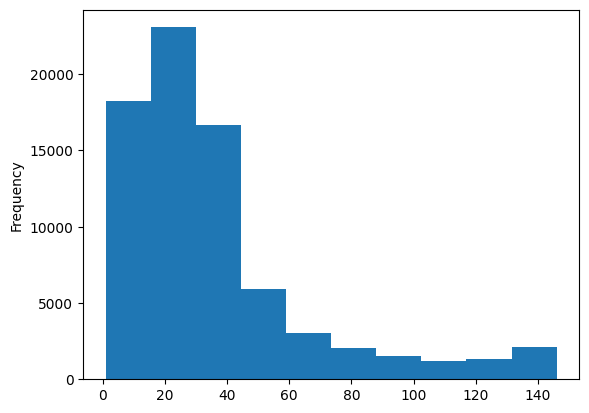

In [55]:
# len 시각화 (label == 0)
import matplotlib.pyplot as plt
df[df["label"] == 0]["len"].plot(kind="hist")


<Axes: ylabel='Frequency'>

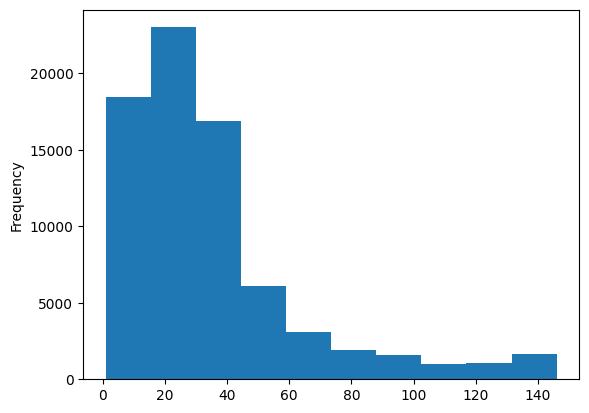

In [56]:
# len 시각화 (label == 1)
import matplotlib.pyplot as plt
df[df["label"] == 1]["len"].plot(kind="hist")


In [57]:
# 데이터 샘플링 df[:1000]
df = df[:1000]
df.shape

(1000, 4)

In [58]:
# 토큰화
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
tokenizer = Okt()
vect = CountVectorizer(tokenizer=tokenizer.morphs)
vectors = vect.fit_transform(df["document"])

/Users/zave/anaconda3/envs/aiffel-research/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### 머신러닝

In [59]:
# 머신러닝 -> 교차검증(f1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(random_state=42)
cross_val_score(model, vectors, df["label"], scoring="f1", cv=5).mean()

0.6538471616167368

## 자연어 전처리

### 어휘 사전 구축

In [60]:
# 토큰화(max_df) N개보다 큰 단어 수 무시
vect = CountVectorizer(tokenizer=tokenizer.morphs, max_df=10)
vectors = vect.fit_transform(df["document"])
model = RandomForestClassifier(random_state=42)
cross_val_score(model, vectors, df["label"], scoring="accuracy", cv=5).mean()

/Users/zave/anaconda3/envs/aiffel-research/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.65

In [61]:
# 토큰화(max_df) N개보다 작은 단어 수 무시
vect = CountVectorizer(tokenizer=tokenizer.morphs, min_df=2)
vectors = vect.fit_transform(df["document"])
model = RandomForestClassifier(random_state=42)
cross_val_score(model, vectors, df["label"], scoring="accuracy", cv=5).mean()

/Users/zave/anaconda3/envs/aiffel-research/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.675

### 불용어(stopword)

In [62]:
# stopwords

text = "함께 탐험하며 성장하는 AI 학교 AIFFEL"
stop_words = ["하며", "ai"]
vect = CountVectorizer(stop_words=stop_words)
words = tokenizer.morphs(text)
vect.fit(words)
vect.vocabulary_

{'함께': 4, '탐험': 2, '성장하는': 1, '학교': 3, 'aiffel': 0}

### 띄어쓰기

In [63]:
import keras
print(keras.__version__)


3.3.3


In [ ]:
# 띄어쓰기
from pykospacing import Spacing
spacing = Spacing()
text = "함께탐험하며성장하는AI학교AIFFEL"
spacing(text)

In [ ]:
# "함께 탐험하며 성장하는 AI 학교 AIFFEL"

### 반복되는 글자 정리

In [ ]:
from soynlp.normalizer import *
emoticon_normalize("하하하하ㅋㅋㅋㅋㅋㅋ 호호ㅗ호호ㅠㅠㅠㅠㅠㅠ", num_repeats=3)

'하하하ㅋㅋㅋ 호호ㅗ호호ㅠㅠㅠ'

### 맞춤법 검사기

In [ ]:
# 맞춤법 검사
from hanspell import spell_checker
text = "알파고 이전, 2015년부터 만들어진 최초의 AI 커뮤니티 모두의연구소.학연, 지연, 모두연이라는 말이나올만큼 AI의 보금자리로서 중요한 역할을 하고 있다."

In [ ]:
# 수정된 문장
result = spell_checker.check(text)
result.checked